In [2]:
%matplotlib inline
import numpy as np
from scipy.linalg import orth
from sklearn.datasets import make_low_rank_matrix, make_blobs
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

### Construct test matrix to be used

Text(0.5, 1.0, 'Singular Values')

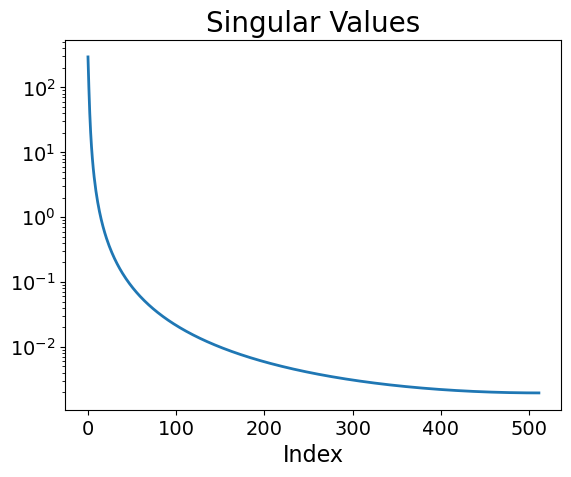

In [3]:
n = 512
x = np.linspace(0,1,n)
X,Y = np.meshgrid(x,x)

A = np.exp(-np.abs(X-Y)/0.5)
u,s,vh = np.linalg.svd(A)

plt.semilogy(s, '-', linewidth = 2.0)
plt.xlabel('Index', fontsize = 16)
plt.title('Singular Values', fontsize = 20)

## 1. Adaptive range finder

In [4]:
def adaptiverangefinder(A, b = 10, maxiter = 25, eps = 1.e-3):
    """ Ensures A \approx QB s.t.
        || A - QB ||_F \leq epsilon
        More efficient implementations possible
    """
    
    _, n = A.shape
    Anrm = np.linalg.norm(A,'fro')**2.
    
    #One step of the adaptive algorithm
    Omega = np.random.randn(n,b)
    Y = np.dot(A,Omega)
    q,r = np.linalg.qr(Y, mode = 'reduced')
    
    Q = np.copy(q)
    B = np.dot(q.T,A)
    
    
    for i in range(maxiter-1):
        Bnrm = np.linalg.norm(B,'fro')**2.
        if (Anrm - Bnrm) <= eps**2.:
            break
            
        Omega = np.random.randn(n,b)
        Y = np.dot(A,Omega)
        q,r = np.linalg.qr(Y, mode = 'reduced')
    
        Q = orth(np.hstack((Q,q)))
        B = np.dot(Q.T,A)
            
        
    return Q, B, i

### Test the adaptive range finder

In [5]:
### Test 1: make sure it is working
Anrm = np.linalg.norm(A,'fro')

q,b,iter = adaptiverangefinder(A, b = 10, eps = 1.e-2*Anrm)
print("Relative eror in the randomized algorithm is ", np.linalg.norm(A-np.dot(q,b))/Anrm)
print("Relative error requested", 1.e-2)
print("number of iterations is", iter, "and numerical rank is",  q.shape[1])

Relative eror in the randomized algorithm is  0.005008049108769777
Relative error requested 0.01
number of iterations is 2 and numerical rank is 30


In [6]:
### Test 2. Find rank corresponding to desired accuracy, compared with SVD

#Relative error
epslst = [1.e-1,1.e-2,1.e-3,1.e-4,1.e-5]

r_eps = [] 
r_svd = []
for i,eps in enumerate(epslst):
    #Absolute error is 
    abserr = eps*Anrm
    
    #Find rank using randomized range finder
    q,b,iter = adaptiverangefinder(A, b = 25, eps = abserr, maxiter = 120)
    r_eps.append(q.shape[1])
    #Find corresponding rank using the SVD
    indlst = np.where(Anrm**2. - np.cumsum(s**2.) < abserr**2.)
   
    r_svd.append(np.min(indlst))

Text(0.5, 1.0, 'Adaptive rank determination')

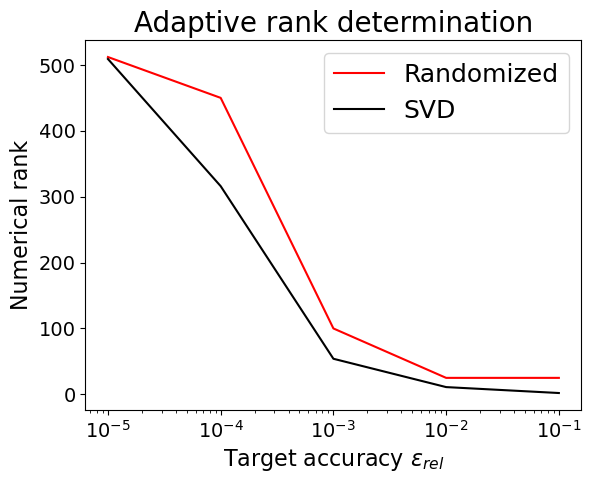

In [7]:
plt.semilogx(epslst,r_eps,'r-',epslst,r_svd, 'k-')
plt.legend(('Randomized','SVD'), fontsize = 18)
plt.xlabel('Target accuracy $\epsilon_{rel}$', fontsize = 16)
plt.ylabel('Numerical rank', fontsize = 16)
plt.title('Adaptive rank determination', fontsize = 20)


## 2. One pass algorithms

In [14]:
def singleview(A, k):
    """
    A = Q(Psi*Q)^+ W
    
    where 
    
    Q is the QR factorization of Y = A * Omega
    W = Psi * A
    """
    
    m,n = A.shape
    
    #Draw random matrices
    ell1 = 2*k+ 1 #k + 10 #2*k+1
    ell2 = 2*ell1+1   #2*ell1+1
    Omega = np.random.randn(n, ell1)
    Psi   = np.random.randn(ell2, m) #Oversample nearly double
    
    # build range
    Y = np.dot(A,Omega)
    Q, _ = np.linalg.qr(Y, mode = 'reduced')
    
    # build corange
    W = np.dot(Psi,A)
    B = np.dot(np.linalg.pinv(np.dot(Psi,Q)),W)
    
    #Convert into SVD
    u,s,vh = np.linalg.svd(B, full_matrices = False)
    u = np.dot(Q,u[:,:k])
    
    return u,s[:k],vh[:k,:]
    

### Test the accuracy of the SingleView approach

Text(0.5, 1.0, 'Frobenius-norm ')

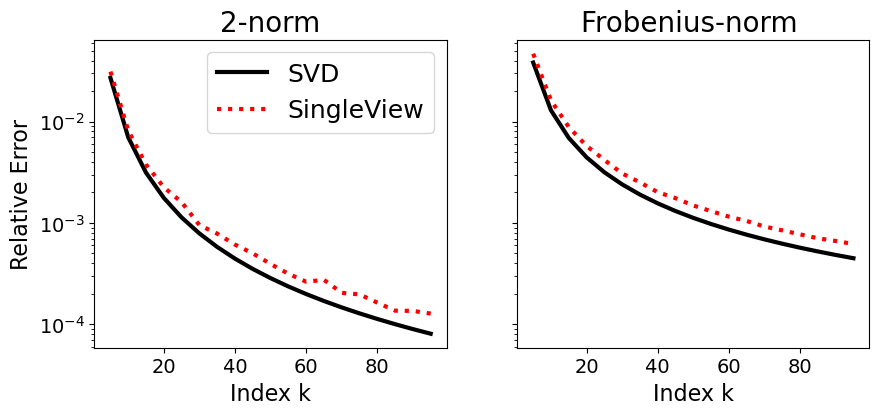

In [15]:
#Compute Frobenius norm of A
klst = range(5,100,5)
n = len(klst)

Anrm = np.linalg.norm(A)

#Error in the 2 and Frobenius norm
err_svd = np.zeros((n,2), dtype = 'd')
err_rsvd = np.zeros((n,2), dtype = 'd')
for k,i in zip(klst,range(n)):
    ur,sr,vrh = singleview(A, k)
    Ah = np.dot(ur,np.dot(np.diag(sr),vrh))
    
    #2-norm
    err_svd[i,0]  = s[k]/s[0]
    err_rsvd[i,0] = np.linalg.norm(A-Ah,2)/s[0] 
    
    #Frobenius norm
    err_svd[i,1]  = np.sqrt(np.sum(s[k:]**2.))/Anrm
    err_rsvd[i,1] = np.linalg.norm(A-Ah,'fro')/Anrm  
    
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy(klst,err_svd[:,0],  'k-', klst,err_rsvd[:,0], 'r:', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Relative Error', fontsize = 16)
ax1.legend({'SVD','SingleView'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy(klst,err_svd[:,1],  'k-', klst,err_rsvd[:,1], 'r:', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

## 3. Randomized subspace iteration

In [10]:
def randomizedsubspaceiteration(A, Omega, q = 0):
    """
        Numerically stable implementation of Y = (AA')^q A Omega
    """
    Y = np.dot(A,Omega)
    Q, _ = np.linalg.qr(Y, mode = 'reduced')
    
    for i in range(q):    
        Y = np.dot(A.T,Q)
        Q, _ = np.linalg.qr(Y, mode = 'reduced')
        Y = np.dot(A, Q)
        Q, _ = np.linalg.qr(Y, mode = 'reduced')
        
    return Q

def randsvdsubspace(A, k, p = 20, q = 0):
    """
        Combine the RandSVD approach with the subspace iteration
    """
    
    m,n = A.shape
    Omega = np.random.randn(n, k+p)
    
    # Stage 1: Randomized subspace iteration
    Q = randomizedsubspaceiteration(A, Omega, q)
        
    # Stage 2: Approximate SVD
    B = np.dot(Q.T,A)
    u,s,vh = np.linalg.svd(B, full_matrices = False)
    
    return np.dot(Q,u[:,:k]), s[:k], vh[:k,:]

Text(0.5, 1.0, 'Frobenius-norm ')

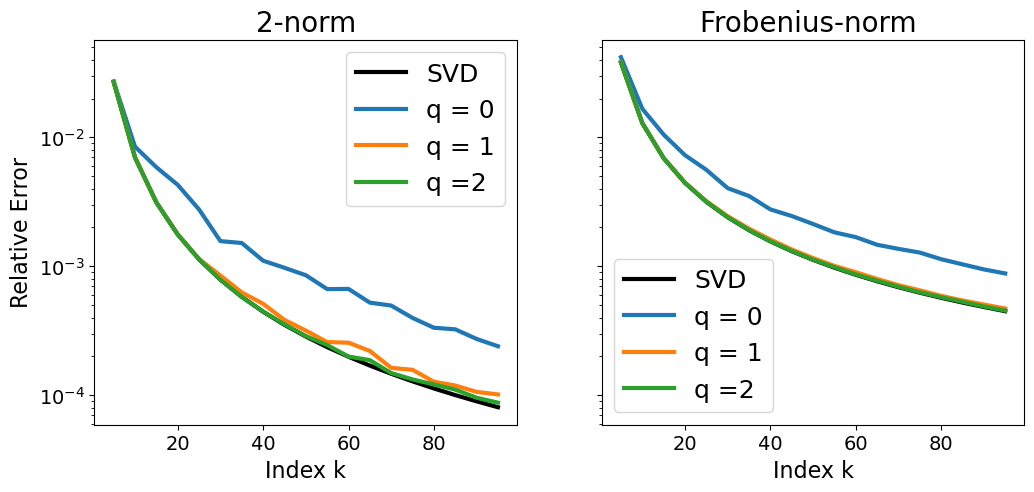

In [11]:
klst = range(5,100,5)
n = len(klst)

# Number of subspace iterations
qlst = [0,1,2]

#Error in the 2 and Frobenius norm
err_svd = np.zeros((n,2), dtype = 'd')
err_rsvd = np.zeros((n,6), dtype = 'd')
for k,i in zip(klst,range(n)):
    
    for j, q in enumerate(qlst):    
        ur,sr,vrh = randsvdsubspace(A, k, p = 5, q = q)
    
        Ah = np.dot(ur,np.dot(np.diag(sr),vrh))
        err_rsvd[i,j] = np.linalg.norm(A-Ah,2)/s[0] 
        err_rsvd[i,3+j] = np.linalg.norm(A-Ah,'fro')/Anrm
    
    #2-norm
    err_svd[i,0]  = s[k]/s[0]
    #Frobenius norm
    err_svd[i,1]  = np.sqrt(np.sum(s[k:]**2.))/Anrm
    
    
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(12,5))
ax1.semilogy(klst,err_svd[:,0],  'k-', klst,err_rsvd[:,:3], linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Relative Error', fontsize = 16)
ax1.legend(('SVD', 'q = 0', 'q = 1', 'q =2 '), fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy(klst,err_svd[:,1],  'k-', klst,err_rsvd[:,3:], linewidth = 3.0)
ax2.legend(('SVD','q = 0', 'q = 1', 'q =2 '), fontsize = 18, loc = 'lower left')
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)